In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import requests
import numpy as np

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import requests
import numpy as np
class Replaybuffer:
    def __init__(self,n_state,n_action):
        self.n_state = n_state
        self.n_action = n_action
        self.size = 2000 #记忆池大小
        self.batchsize = 10

        #给记忆五元组申请空间
        self.s = np.empty(shape = (self.size, self.n_state), dtype=np.float32)
        self.a = np.random.randint(low=0, high=n_action, size=self.size, dtype=np.uint8)
        self.r = np.empty(self.size, dtype=np.float32)
        self.done = np.random.randint(low=0, high=2, size=self.size, dtype=np.uint8)
        self.s_ = np.empty(shape = (self.size, self.n_state), dtype=np.float32)

        self.t = 0
        self.tmax = 0  # 初始化tmax属性 ##后加

    def add_memo(self,s,a,r,done,s_): #需要实现功能：1.交互后增加记忆 2.sample batch时取出记忆
    #第t步向记忆池里加记忆
        #print("s:", s.shape)  # 打印s的形状
        #print("Expected s shape:", (self.n_state,))
        self.s[self.t] = s
        self.a[self.t] = a
        self.r[self.t] = r
        self.done[self.t] = done
        self.s_[self.t] = s_
        self.t = self.t + 1 if self.t + 1 < self.size else 1 #t到2001时，重新从1开始加
        self.tmax = max(self.tmax, self.t +1)



    def sample(self):
    #采样逻辑：Buffer里的经验如果比batchsize多，那就sample;如果比batchsize少，那就有几个取几个
        '''if self.tmax > self.size:
            idxes = random.sample(range(0, self.tmax),self.size)
        else:
            idxes = random.sample(range(0, self.tmax))'''

        if self.tmax > self.batchsize:
           k = self.batchsize  # 如果缓冲区样本数大于等于批次大小，使用批次大小
        else:
           k = self.tmax  # 否则，使用缓冲区的实际样本数量

        idxes = random.sample(range(0, self.tmax), k)  # 使用确定的k值抽样

        batch_s = []
        batch_a = []
        batch_r = []
        batch_done = []
        batch_s_ = []

        for idx in idxes: #抽64个数据
            batch_s.append(self.s[idx])
            batch_a.append(self.a[idx])
            batch_r.append(self.r[idx])
            batch_done.append(self.done[idx])
            batch_s_.append(self.s_[idx])

        #把numpy转换成torch的tensor
        batch_s = torch.as_tensor(np.asarray(batch_s),dtype=torch.float32)
        batch_a = torch.as_tensor(np.asarray(batch_a),dtype=torch.int64).unsqueeze(-1) #升维：从(2)升到(2,1)
        batch_r = torch.as_tensor(np.asarray(batch_r),dtype=torch.float32).unsqueeze(-1)
        batch_done = torch.as_tensor(np.asarray(batch_done),dtype=torch.float32).unsqueeze(-1)
        batch_s_ = torch.as_tensor(np.asarray(batch_s_),dtype=torch.float32)

        return batch_s, batch_a, batch_r, batch_done, batch_s_
class Qnetwork(nn.Module):
      def __init__(self, n_input, n_output):
          super().__init__() #继承Module父类

          self.net = nn.Sequential(
              nn.Linear(in_features= n_input, out_features = 128),
              nn.ReLU(), #nn.Tanh(),
              nn.Linear(in_features= 128, out_features = n_output))

      def forward(self,x):
           return self.net(x) #前向传播

      def act(self,obs): #面对s，找到最大的Q值（因为神经网络输出的不只是最大Q值），输出对应的action
          obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
          q_value = self(obs_tensor.unsqueeze(0)) #转化成行向量
          max_q_idx = torch.argmax(input=q_value)
          action = max_q_idx.detach().item() #最大Q值索引对应的action
          return action


class AgentwoTN:
   def __init__(self, n_input, n_output, Gamma=0.97, learning_rate = 0.01):
            self.n_input = n_input
            self.n_output = n_output
            self.learning_rate = learning_rate
            self.Gamma = Gamma
            self.memo = Replaybuffer(self.n_input, self.n_output) #先实例化Agent，得到memo，Memo再实例化Replaybuffer

            self.online_net = Qnetwork(self.n_input, self.n_output)

            self.optimizer = torch.optim.Adam(self.online_net.parameters(),lr=self.learning_rate)


class Agent:
   def __init__(self, n_input, n_output, Gamma=0.97, learning_rate = 0.01):
            self.n_input = n_input
            self.n_output = n_output
            self.learning_rate = learning_rate
            self.Gamma = Gamma
            self.memo = Replaybuffer(self.n_input, self.n_output) #先实例化Agent，得到memo，Memo再实例化Replaybuffer

            #两个网络结构相同，可以用同一个类实例化
            self.online_net = Qnetwork(self.n_input, self.n_output)
            self.target_net = Qnetwork(self.n_input, self.n_output)

            self.optimizer = torch.optim.Adam(self.online_net.parameters(),lr=self.learning_rate)


In [ ]:
env = gym.make('CartPole-v1')
n_input = env.observation_space.shape[0]
n_output = env.action_space.n

np.random.seed(42)

epsilon_decay = 10000
epsilon_start = 1.0 #best value from tuning hyperparameters
epsilon_end = 0.1
target_update = 5
n_step = 500
n_episode = 1000
TARGET_UPDATE = 10
Gamma=0.97
learning_rate = 0.01


##initialise agent without Target Network but with Experience Replay
agent = AgentwoTN(n_input, n_output)
episode1_array = []
rewards1_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000

s = env.reset()
for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end])
        random_sample = random.random()
        if random_sample <= epsilon:
            a = env.action_space.sample()
        else:
            a = agent.online_net.act(s)

        s_, r, done, _ = env.step(a)
        epi_reward += r

        # Learning process
        target_q_values = agent.online_net(torch.tensor(s_).unsqueeze(0))
        target_q = r + agent.Gamma * (1 - done) * target_q_values.max(dim=1)[0]

        pred_q_values = agent.online_net(torch.tensor(s).unsqueeze(0))
        pred_q = pred_q_values[0][a]

        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step()

        s = s_

        if done:
            s = env.reset()
            Reward_list[episode] = epi_reward
            break

    if episode % TARGET_UPDATE == 0:
        #agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode1_array.append(episode)
        rewards1_array.append(reward)
x1 = episode1_array
y1 = rewards1_array




<ipython-input-19-fbe07e8c97cd>:46: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.smooth_l1_loss(target_q, pred_q)


Episode:0
Reward:nan
Episode:10
Reward:18.6
Episode:20
Reward:15.9
Episode:30
Reward:22.6
Episode:40
Reward:24.2
Episode:50
Reward:23.3
Episode:60
Reward:23.4
Episode:70
Reward:17.7
Episode:80
Reward:25.9
Episode:90
Reward:18.0
Episode:100
Reward:9.5
Episode:110
Reward:22.5
Episode:120
Reward:14.5
Episode:130
Reward:26.6
Episode:140
Reward:24.0
Episode:150
Reward:12.8
Episode:160
Reward:14.9
Episode:170
Reward:9.9
Episode:180
Reward:9.8
Episode:190
Reward:13.7
Episode:200
Reward:9.7
Episode:210
Reward:10.8
Episode:220
Reward:16.4
Episode:230
Reward:17.6
Episode:240
Reward:15.7
Episode:250
Reward:19.8
Episode:260
Reward:21.1
Episode:270
Reward:34.9
Episode:280
Reward:21.9
Episode:290
Reward:9.6
Episode:300
Reward:29.5
Episode:310
Reward:15.7
Episode:320
Reward:16.9
Episode:330
Reward:14.3
Episode:340
Reward:11.7
Episode:350
Reward:33.2
Episode:360
Reward:25.0
Episode:370
Reward:22.8
Episode:380
Reward:13.6
Episode:390
Reward:10.5
Episode:400
Reward:15.4
Episode:410
Reward:14.6
Episode:4

In [ ]:

##DQN (with target network AND experience replay)
s = env.reset()
np.random.seed(42)
agent = Agent(n_input, n_output)
episode2_array = []
rewards2_array = []
TARGET_UPDATE = 10
Reward_list = np.empty(shape=n_episode)
n_episode = 1000

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end]) #插值


        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode2_array.append(episode)
        rewards2_array.append(reward)



Episode:0
Reward:nan
Episode:10
Reward:23.0
Episode:20
Reward:21.2
Episode:30
Reward:12.0
Episode:40
Reward:22.7
Episode:50
Reward:18.3
Episode:60
Reward:24.3
Episode:70
Reward:28.8
Episode:80
Reward:34.3
Episode:90
Reward:29.4
Episode:100
Reward:75.6
Episode:110
Reward:87.1
Episode:120
Reward:106.5
Episode:130
Reward:196.3
Episode:140
Reward:190.7
Episode:150
Reward:124.6
Episode:160
Reward:94.7
Episode:170
Reward:81.7
Episode:180
Reward:32.3
Episode:190
Reward:17.9
Episode:200
Reward:15.7
Episode:210
Reward:110.4
Episode:220
Reward:126.5
Episode:230
Reward:124.8
Episode:240
Reward:203.5
Episode:250
Reward:121.9
Episode:260
Reward:176.5
Episode:270
Reward:198.1
Episode:280
Reward:175.5
Episode:290
Reward:101.0
Episode:300
Reward:174.5
Episode:310
Reward:132.7
Episode:320
Reward:87.2
Episode:330
Reward:177.6
Episode:340
Reward:248.6
Episode:350
Reward:144.1
Episode:360
Reward:135.4
Episode:370
Reward:185.1
Episode:380
Reward:163.0
Episode:390
Reward:93.1
Episode:400
Reward:73.8
Episode

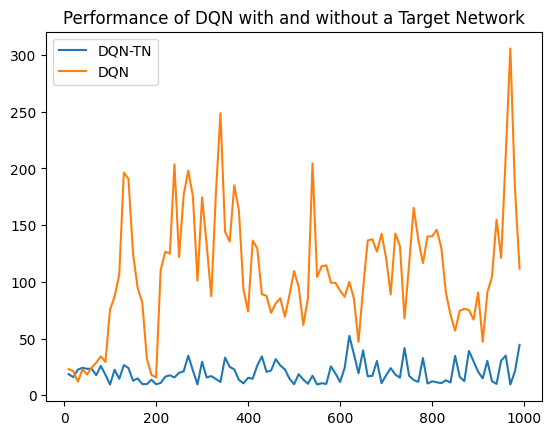

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#set x and y for the final plot
#x = episode1_array
#y = rewards1_array


plt.title("Performance of DQN with and without a Target Network")
plt.plot(episode1_array, rewards1_array, label = "DQN-TN")
#plt.plot(x1, y1, label = "temp = 0.9")
plt.plot(episode2_array, rewards2_array, label = "DQN")
plt.legend()
plt.show()